In [2]:
%matplotlib inline
import pandas as pd
import csv
import ast
import math
import json
import zipfile
from datetime import datetime
import tensorflow as tf
from sklearn.cluster import estimate_bandwidth, MeanShift
from sklearn.cluster import MiniBatchKMeans
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [48, 30]

In [3]:
#Load the training and testing data
df_train =pd.read_csv('data_train.csv')
df_test =pd.read_csv('data_test.csv')

#Changing the TIME to Hours
df_train['time_entry']=pd.to_timedelta(df_train['time_entry'])/pd.offsets.Hour(1)
df_train['time_exit']=pd.to_timedelta(df_train['time_exit'])/pd.offsets.Hour(1)

df_test['time_entry']=pd.to_timedelta(df_test['time_entry'])/pd.offsets.Hour(1)
df_test['time_exit']=pd.to_timedelta(df_test['time_exit'])/pd.offsets.Hour(1)

In [4]:
#Function to create a journey from trajectories
def create_polyline_x(x_entry):
    t_x=np.array(x_entry)
    return [t_x]

In [6]:
def get_clusters(coords):
    clusters = pd.DataFrame({
        'approx_latitudes': coords[:,0].round(4),
        'approx_longitudes': coords[:,1].round(4)
    })
    #Removing duplicate coordinates
    clusters = clusters.drop_duplicates(['approx_latitudes', 'approx_longitudes'])
    clusters = clusters.as_matrix()
    #Setting the bandwidth of clusters
    bandwidth = estimate_bandwidth(clusters, quantile=0.00002)
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True).fit(clusters)
    #return Meanshift object
    return ms

In [6]:
#Group Trajectories by Hash Making them a full Journey
hash_group=df_train.groupby(['hash'])
#Taking all the coordinates to create clusters.
polyline =hash_group[['x_entry','y_entry']].apply(lambda x:create_polyline_x(x))
feats = polyline.to_frame(name='polyline')
latlong = np.array([[p[0][0][1], p[0][0][0]] for p in feats['polyline'] if len(p)>0])
ms = get_clusters(latlong)

/home/nuclearvodka/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [27]:
#Set points to Clusters and add to dataframes
df_train.loc[:, 'pickup_cluster'] = ms.predict(df_train[['y_entry', 'x_entry']])
df_train.loc[:, 'dropoff_cluster'] = ms.predict(df_train[['y_exit', 'x_exit']])

#Add only pick up clusters to Test data as End points are incomplete
df_test.loc[:, 'pickup_cluster'] = ms.predict(df_test[['y_entry', 'x_entry']])
#test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

#Write to a CSV File as a buffer save to conserver on RAM
df_train.to_csv(r'Clusters_Train_Panda.csv')

In [25]:
#Function that adds Exit Clusters to Test Data
def add_exit_clusters(df_test):
    #Creating a blank series 
    Type_new = pd.Series([]) 
    #Checks every entry if it has exit points if yes then predict the cluster for them.
    for i in range(len(df_test)):
        if str(df_test['y_exit'][i]) == "nan":
            Type_new[i]="nan"
        else:
            Type_new[i] = ms.predict([[df_test['y_exit'][i], df_test['x_exit'][i]]])[0]
    #inser the new column
    df_test.insert(11, "dropoff_cluster", Type_new) 
    return df_test

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


In [ ]:
df_test = add_exit_clusters(df_test)
df_test.to_csv(r'Clusters_Test_Panda.csv')

In [26]:
#Shows the current entries in the pandas dataset
df_test.head(10)

pickup_cluster  Unnamed: 0                                 hash  \
0           36024           0  00032f51796fd5437b238e3a9823d13d_31   
1           36024           1  00032f51796fd5437b238e3a9823d13d_31   
2           36024           2  00032f51796fd5437b238e3a9823d13d_31   
3           36024           3  00032f51796fd5437b238e3a9823d13d_31   
4           36024           4  00032f51796fd5437b238e3a9823d13d_31   
5           36024           5  000479418b5561ab694a2870cc04fd43_25   
6           36024           6  000479418b5561ab694a2870cc04fd43_25   
7           36024           7  000479418b5561ab694a2870cc04fd43_25   
8           36024           8  000506a39775e5bca661ac80e3f466eb_29   
9           36024           9  000506a39775e5bca661ac80e3f466eb_29   

                                 trajectory_id  time_entry  time_exit   vmax  \
0   traj_00032f51796fd5437b238e3a9823d13d_31_0   11.721389  11.838056    NaN   
1   traj_00032f51796fd5437b238e3a9823d13d_31_2   12.360278  12.360278   0.00   
2   traj_00032f51796fd5437b238e3a9823d13d_31_3   12.574167  13.236389    NaN   
3   traj_00032f51796fd5437b238e3a9823d13d_31_4   13.425833  13.720278    NaN   
4   traj_00032f51796fd5437b238e3a9823d13d_31_5   15.058889  15.175556    NaN   
5   traj_000479418b5561ab694a2870cc04fd43_25_0    8.139722   8.335556  17.29   
6   traj_000479418b5561ab694a2870cc04fd43_25_6   12.139722  12.223333    NaN   
7  traj_000479418b5561ab694a2870cc04fd43_25_10   15.485833  15.515556    NaN   
8   traj_000506a39775e5bca661ac80e3f466eb_29_1    8.751389   8.842500    NaN   
9   traj_000506a39775e5bca661ac80e3f466eb_29_2   11.150556  11.150556    NaN   

    vmin  vmean       x_entry       y_entry dropoff_cluster        x_exit  \
0    NaN    NaN  3.773413e+06 -1.909828e+07           36024  3.773111e+06   
1   0.00   0.00  3.773199e+06 -1.914354e+07            9722  3.773199e+06   
2    NaN    NaN  3.763760e+06 -1.921342e+07            9202  3.771757e+06   
3    NaN    NaN  3.773385e+06 -1.911344e+07           17575  3.773131e+06   
4    NaN    NaN  3.773118e+06 -1.914490e+07             nan           NaN   
5  17.29  17.29  3.771380e+06 -1.933274e+07            4890  3.769933e+06   
6    NaN    NaN  3.771380e+06 -1.933274e+07           26284  3.769983e+06   
7    NaN    NaN  3.769978e+06 -1.934136e+07             nan           NaN   
8    NaN    NaN  3.760880e+06 -1.910042e+07            8788  3.759312e+06   
9    NaN    NaN  3.755349e+06 -1.916135e+07           18189  3.755349e+06   

         y_exit  
0 -1.914508e+07  
1 -1.914354e+07  
2 -1.911092e+07  
3 -1.914465e+07  
4           NaN  
5 -1.934095e+07  
6 -1.934265e+07  
7           NaN  
8 -1.908280e+07  
9 -1.916135e+07

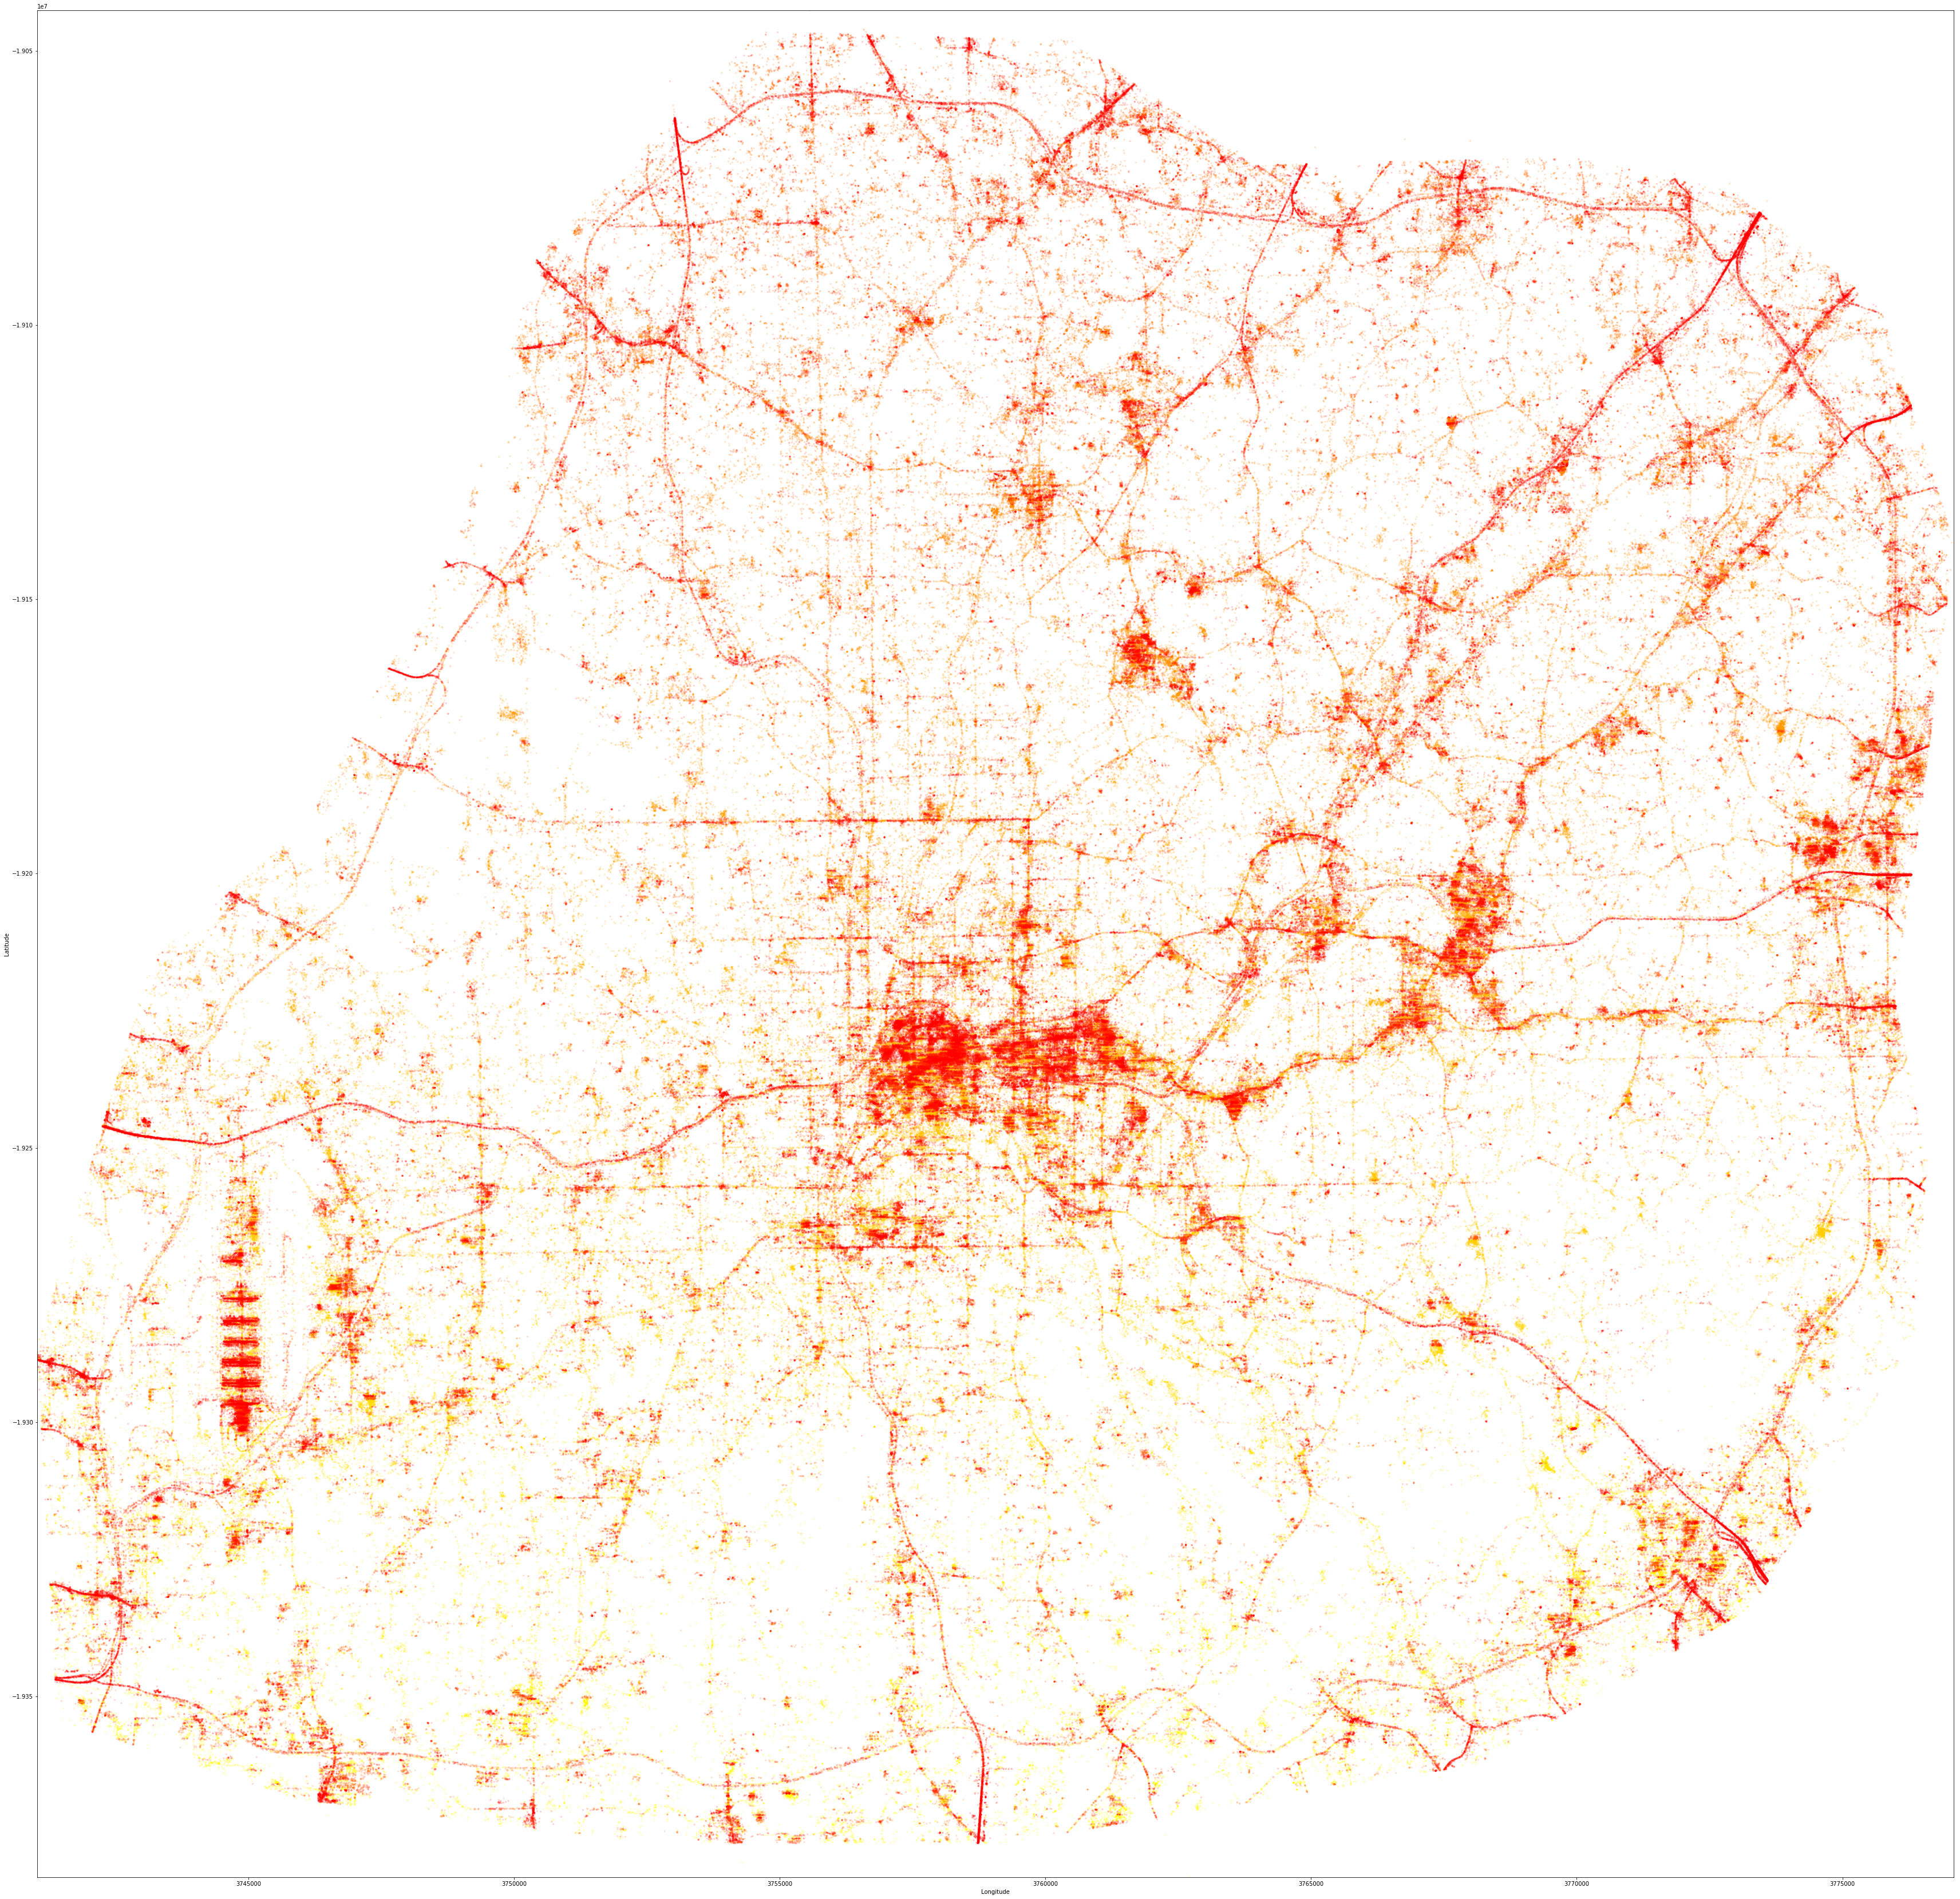

In [25]:
def plot_clusters(df_train):
    fig, ax = plt.subplots(ncols=1, nrows=1)
    ax.scatter(df_train.x_entry.values, df_train.y_entry.values, s=10, lw=0,
               c=df_train.pickup_cluster.values, cmap='autumn', alpha=0.2)
    ax.set_xlim((3.741027e+06,3.777099e+06))
    ax.set_ylim((-1.938291e+07,-1.904266e+07))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.rcParams['figure.figsize'] = [60, 60]
    plt.show()

In [12]:
#Compass Directions between two points NOT USED AS FINAL FEATURES
def compass(x1,y1,x2,y2):
    x3 = x2-x1
    y3 = y2-y1
    if x3 == 0:
        if y3 <= 0 :
            return "South"
        elif y3 >= 0:
            return "North"
    elif y3 == 0:
        if x3 >= 0:
            return "East"
        elif x3 <= 0:
            return "West"
    m = x3/y3                 
    theta = math.degrees(math.atan(m))
    if x3 < 0 and y3 < 0:
        theta = 180+theta
    elif x3 < 0 and y3 > 0 :
        theta = 360+theta
    elif x3 > 0 and y3 > 0:
        theta = 0+theta
    elif x3 > 0 and y3 < 0:
        theta = 180+theta
    #Setting the parameters for N,S,W,E
    if theta >= 337.5  and theta <= 360:
        return "North"
    elif theta >= 0 and theta <= 22.5:
        return "North"
    elif theta >= 22.5 and theta <= 67.5:
        return "North East"
    elif theta >= 67.5 and theta <= 112.5:
        return "East"
    elif theta >= 112.5 and theta <= 157.5:
        return "South East"
    elif theta >= 157.5 and theta <= 202.5:
        return "South"
    elif theta >= 202.5 and theta <= 247.5:
        return "South West"
    elif theta >= 247.5 and theta <= 292.5:
        return "West"
    elif theta >= 292.5 and theta <= 337.5:
        return "North West"
    else:
        print(theta)
        return "Fail"

In [8]:
#Read file
df_train =pd.read_csv('Clusters_Train_Panda.csv')
#Taking only variables from data
df_values = df_train.loc[:,['time_entry','time_exit','x_entry', 'y_entry','x_exit','y_exit','pickup_cluster','dropoff_cluster']]
#Take the values from those variables
values_train = df_values.values

In [52]:
#Read test file
df_test =pd.read_csv('Clusters_Test_Panda.csv')
#Take only the variables from data
df_values_test = df_test.loc[:,['time_entry','time_exit','x_entry', 'y_entry','x_exit','y_exit','trajectory_id','pickup_cluster','dropoff_cluster']]
#Take the values from those variables
values_test = df_values_test.values

In [9]:
def train_list(df_train,values):
    #Creating a list for training of a network
    hash_list = []
    same_hash = []
    data_processing_list = []
    location = "Clustering_Train_Features_2.csv"
    x = 0
    i = 0
    hash_unique = 0
    while x < len(df_train):
        if x % 100000 == 0:
            print(x)
        if x < len(df_train):
            if df_train['hash'][x] == df_train['hash'][x+1]:
                #if hash_unique == 0 :
                entry = [values[x][0],values[x][1],values[x][2],values[x][3],values[x][6]]
                y_labels = [values[x][4],values[x][5]]
                x +=1
                same_hash.append(entry)
                hash_list.append([same_hash,y_labels])
                with open(location,'a') as writeFile:
                    writer = csv.writer(writeFile)
                    writer.writerows(hash_list)
                writeFile.close()
                hash_list = []
            else:
                entry = [values[x][0],values[x][1],values[x][2],values[x][3],values[x][6]]
                y_labels = [values[x][4],values[x][5]]
                same_hash.append(entry)
                hash_list.append([same_hash,y_labels])
                with open(location,'a') as writeFile:
                    writer = csv.writer(writeFile)
                    writer.writerows(hash_list)
                writeFile.close()
                x +=1
                hash_list = []
                same_hash = []
                y_labels = []
                data_processing_list = []
                entry = []

In [ ]:
train_list(df_train,values_train)

In [50]:
def test_list(df_train,values):
    #Creating a list for training of a network
    hash_list = []
    same_hash = []
    data_processing_list = []
    location = "Clustering_Test_Features_2.csv"
    x = 0
    i = 0
    hash_unique = 0
    while x < len(df_train):
        if x % 100000 == 0:
            print(x)
        if x < len(df_train):
            if df_train['hash'][x] == df_train['hash'][x+1] and str(values[x][4]) != "nan":
                entry = [values[x][0],values[x][1],values[x][2],values[x][3],values[x][7]]
                y_labels = [values[x][4],values[x][5]]
                traj = [values[x][6]]
                x +=1
                same_hash.append(entry)
                hash_list.append([same_hash,y_labels,traj])
                with open(location,'a') as writeFile:
                    writer = csv.writer(writeFile)
                    writer.writerows(hash_list)
                writeFile.close()
                hash_list = []
            else:
                entry = [values[x][0],values[x][1],values[x][2],values[x][3],values[x][7]]
                y_labels = [values[x][4],values[x][5]]
                traj = [values[x][6]]
                same_hash.append(entry)
                hash_list.append([same_hash,y_labels,traj])
                with open(location,'a') as writeFile:
                    writer = csv.writer(writeFile)
                    writer.writerows(hash_list)
                writeFile.close()
                x +=1
                hash_list = []
                same_hash = []
                y_labels = []
                data_processing_list = []
                entry = []

In [53]:
test_list(df_test,values_test)

0
100000
200000


KeyError: 202937

In [13]:
def train_features(location):
    with open(location,'r') as f:
        reader = csv.reader(f)
        your_list = list(reader)
    f.close()
    data = []
    enc = OneHotEncoder()
    enc.fit([["North"],["North East"],["East"],["South East"],["South"],["South West"],["West"],["North West"]])
    for k in range(len(your_list)):
        if k % 100000 == 0:
            print(k)
        x = your_list[k][0]
        x = ast.literal_eval(x)
        x = [n for n in x]


        len_x = len(x)
        if len_x >= 2:
            i = 0

            Feature_1 = len_x #Length of X Number of points in trajectory
            Avg_Vel_X  = []
            Avg_Vel_Y  = []
            Avg_Eud_D  = []
            Avg_Time   = []
            X_Distance = []
            Y_Distance = []
            #Getting Average Velocities of the trajectory
            for j in range(len_x):
                Ft_1 = x[j][0]
                Ft_2 = x[j][1] 
                Ft_3 = Ft_2-Ft_1
                Ft_4 = x[j][2] #X Entry first Point
                Ft_5 = x[j][3] #Y Entry First Point
                if j == len_x-1:
                    break
                else:
                    Ft_6 = x[j+1][2] #Second point start X/ First point End X
                    Ft_7 = x[j+1][3] #Second point start Y/ First point End Y
                    Ft_8 = Ft_6-Ft_4  #Distance Travelled X direction
                    Ft_9 = Ft_7-Ft_5  #Distance Travelled Y direction
                    if Ft_3 == 0:
                        Ft_10 = 0
                        Ft_11 = 0
                    else:
                        Ft_10 = (Ft_8)/Ft_3 #Velocity X
                        Ft_11 = (Ft_9)/Ft_3 #Velocity Y
                    Ft_17 = math.sqrt((Ft_9**2)+(Ft_8**2))
                    Avg_Vel_X.append(Ft_10)
                    Avg_Vel_Y.append(Ft_11)
                    Avg_Eud_D.append(Ft_17)
                    Avg_Time.append(Ft_2-Ft_1)
                    X_Distance.append(Ft_8)
                    Y_Distance.append(Ft_9)

            Feature_2 = (sum(Avg_Vel_X)/len(Avg_Vel_X)) #Average X Velocity
            Feature_3 = (sum(Avg_Vel_Y)/len(Avg_Vel_Y)) #Average Y Velocity

            #Feature_16 = math.sqrt((Feature_9**2)+(Feature_8**2)) #Euclidean distance between two points
            Feature_4 = (sum(Avg_Eud_D)/len(Avg_Eud_D)) #Average Euclidean distance between two points
            Feature_5 = (sum(Avg_Time)/len(Avg_Time)) #Average Time between two points

            Feature_6 = x[len_x-1][0] #Last Point Entry time
            Feature_7 = x[len_x-1][1] #Last Point Exit time
            Feature_8 = Feature_7-Feature_6 #Time of travel for last point

            Feature_9 = x[len_x-1][2] #X Entry Last Point
            Feature_10 = x[len_x-1][3] #Y Entry Last Point

            Feature_11 = Feature_9- x[len_x-2][2] #Last Change in X
            Feature_12 = Feature_10 - x[len_x-2][3] #Last Change in Y
            Feature_13 = Feature_7 - x[len_x-2][1] #Time Trip Last and before last point

            if Feature_13 == 0:
                Feature_14 = 0
                Feature_15 = 0
            else:
                Feature_14 = Feature_9/Feature_13 #Last Vel X
                Feature_15 = Feature_10/Feature_13 #Last Vel Y

            Feature_16 = math.sqrt((Feature_11**2)+(Feature_12**2)) #Last ED distance 
            Feature_17 = sum(X_Distance) #Total Distance Travelled by X 
            Feature_18 = sum(Y_Distance) #Total Distance Travelled by y
            Feature_19 = Feature_17/len(X_Distance) #Average Distance Travelled by X
            Feature_20 = Feature_18/len(Y_Distance) #Average Distance Travelled by Y

            compass_directions = compass(x[len_x-2][2],x[len_x-2][3],Feature_9,Feature_10)

            cd_a = enc.transform([[compass_directions]]).toarray()
            Feature_21 = cd_a[0][0]
            Feature_22 = cd_a[0][1]
            Feature_23 = cd_a[0][2]
            Feature_24 = cd_a[0][3]
            Feature_25 = cd_a[0][4]
            Feature_26 = cd_a[0][5]
            Feature_27 = cd_a[0][6]
            Feature_28 = cd_a[0][7]

            Feature_29 = x[len_x-2][1] -x[len_x-2][0] #Before last Time Distance
            Feature_30 = x[len_x-2][2] #Before Last X point
            Feature_31 = x[len_x-2][3] #Before Last Y point
            Feature_32 = x[len_x-2][0] #Before Last Time Entrance
            Feature_33 = x[len_x-2][1] #Before Last Time Exit

            if Feature_11 == 0:
                Feature_34 = 0
            else:
                Feature_34 = Feature_12/Feature_11

            if (3750901.5068 <= Feature_9) and (Feature_9 <= 3770901.5068):
                Feature_35 = 1
            else:
                Feature_35 = 0

            if ( -19268905.6133 <= Feature_10) and (Feature_10 <= -19208905.6133):
                Feature_36 = 1
            else:
                Feature_36 = 0

            Y_C = -19208905.6133 + (-19268905.6133+19208905.6133)/2
            X_C = 3750901.5068+(3770901.5068-3750901.5068)/2

            #Last Point ED distance away from center
            Feature_37 = math.sqrt(((X_C-Feature_9)**2)+((Y_C-Feature_10)**2))
            Feature_38 = x[len_x-1][4]
            #Y = x[len_x-1][5]
        elif len_x == 1:

            Feature_1 = len_x #Length of X Number of points in trajectory
            Avg_Vel_X  = []
            Avg_Vel_Y  = []
            Avg_Eud_D  = []
            Avg_Time   = []
            X_Distance = []
            Y_Distance = []
            #Getting Average Velocities of the trajectory
            for j in range(len_x):
                Ft_1 = x[j][0]
                Ft_2 = x[j][1] 
                Ft_3 = Ft_2-Ft_1
                Ft_4 = x[j][2] #X Entry first Point
                Ft_5 = x[j][3] #Y Entry First Point
                if j == len_x-1:
                    break
                else:
                    Avg_Time.append(Ft_2-Ft_1)

            Feature_2 = 0 #Average X Velocity
            Feature_3 = 0 #Average Y Velocity

            Feature_4 = 0 #Average Euclidean distance between two points        
            Feature_5 = 0 #Average Time between two points
            Feature_6 = x[len_x-1][0] #Last Point Entry time
            Feature_7 = x[len_x-1][1] #Last Point Exit time

            Feature_8 = Feature_7-Feature_6 #Time of travel for last point
            Feature_9 = x[len_x-1][2] #X Entry Last Point
            Feature_10 = x[len_x-1][3] #Y Entry Last Point
            Feature_11 = 0 #Last Change in X
            Feature_12 = 0 #Last Change in Y
            Feature_13 = 0 #Time Trip Last and before last point

            if Feature_13 == 0:
                Feature_14 = 0
                Feature_15 = 0
            else:
                Feature_14 = Feature_9/Feature_13 #Last Vel X
                Feature_15 = Feature_10/Feature_13 #Last Vel Y

            Feature_16 = 0 #Last ED distance 
            Feature_17 = 0 #Total Distance Travelled by X 
            Feature_18 = 0 #Total Distance Travelled by y
            Feature_19 = 0 #Average Distance Travelled by X
            Feature_20 = 0 #Average Distance Travelled by Y
            

            Feature_21 = 0
            Feature_22 = 0
            Feature_23 = 0
            Feature_24 = 0
            Feature_25 = 0
            Feature_26 = 0
            Feature_27 = 0
            Feature_28 = 0
            Feature_29 = 0 #Before last Time Distance
            Feature_30 = 0 #Before Last X point
            Feature_31 = 0 #Before Last Y point
            Feature_32 = 0 #Before Last Time Entrance
            Feature_33 = 0 #Before Last Time Exit

            if Feature_11 == 0:
                Feature_34 = 0
            else:
                Feature_34 = 0


            if (3750901.5068 <= Feature_9) and (Feature_9 <= 3770901.5068):
                Feature_35 = 1
            else:
                Feature_35 = 0

            if ( -19268905.6133 <= Feature_10) and (Feature_10 <= -19208905.6133):
                Feature_36 = 1
            else:
                Feature_36 = 0

            Y_C = -19208905.6133 + (-19268905.6133+19208905.6133)/2
            X_C = 3750901.5068+(3770901.5068-3750901.5068)/2

            #Last Point ED distance away from center
            Feature_37 = math.sqrt(((X_C-Feature_9)**2)+((Y_C-Feature_10)**2))
            Feature_38 = x[0][4]
            
        y = your_list[k][1]
        y = ast.literal_eval(y)
        y = [n for n in y]

        #Direction Should be added here
        Label_X =  y[0]
        Label_Y =  y[1]
        
        if (3750901.5068 <= Label_X) and (Label_X <= 3770901.5068) and ( -19268905.6133 <= Label_Y) and (Label_Y <= -19208905.6133):
            Output = 1
        else:
            Output = 0
            #Traject =  your_list[k][2]
        #Output = your_list[k][1]
        entry = [Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,
                 Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,
                 Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,
                 Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,
                 Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Label_X,Label_Y,Output]

        data.append(entry)

    return data

In [14]:
location = "Clustering_Train_Features_1.csv"
data_train = train_features(location)

0
100000
200000
300000
400000
500000
600000
700000
800000


In [54]:
def test_features(location):
    with open(location,'r') as f:
        reader = csv.reader(f)
        your_list = list(reader)
    f.close()
    data = []
    enc = OneHotEncoder()
    enc.fit([["North"],["North East"],["East"],["South East"],["South"],["South West"],["West"],["North West"]])
    for k in range(len(your_list)):
        if k % 100000 == 0:
            print(k)
        x = your_list[k][0]
        x = ast.literal_eval(x)
        x = [n for n in x]


        len_x = len(x)
        if len_x >= 2:
            i = 0

            Feature_1  = len_x #Length of X Number of points in trajectory
            Avg_Vel_X  = []
            Avg_Vel_Y  = []
            Avg_Eud_D  = []
            Avg_Time   = []
            X_Distance = []
            Y_Distance = []
            #Getting Average Velocities of the trajectory
            for j in range(len_x):
                Ft_1 = x[j][0]
                Ft_2 = x[j][1] 
                Ft_3 = Ft_2-Ft_1
                Ft_4 = x[j][2] #X Entry first Point
                Ft_5 = x[j][3] #Y Entry First Point
                if j == len_x-1:
                    break
                else:
                    Ft_6 = x[j+1][2] #Second point start X/ First point End X
                    Ft_7 = x[j+1][3] #Second point start Y/ First point End Y
                    Ft_8 = Ft_6-Ft_4  #Distance Travelled X direction
                    Ft_9 = Ft_7-Ft_5  #Distance Travelled Y direction
                    if Ft_3 == 0:
                        Ft_10 = 0
                        Ft_11 = 0
                    else:
                        Ft_10 = (Ft_8)/Ft_3 #Velocity X
                        Ft_11 = (Ft_9)/Ft_3 #Velocity Y
                    Ft_17 = math.sqrt((Ft_9**2)+(Ft_8**2))
                    Avg_Vel_X.append(Ft_10)
                    Avg_Vel_Y.append(Ft_11)
                    Avg_Eud_D.append(Ft_17)
                    Avg_Time.append(Ft_2-Ft_1)
                    X_Distance.append(Ft_8)
                    Y_Distance.append(Ft_9)

            Feature_2 = (sum(Avg_Vel_X)/len(Avg_Vel_X)) #Average X Velocity
            Feature_3 = (sum(Avg_Vel_Y)/len(Avg_Vel_Y)) #Average Y Velocity

            #Feature_16 = math.sqrt((Feature_9**2)+(Feature_8**2)) #Euclidean distance between two points
            Feature_4 = (sum(Avg_Eud_D)/len(Avg_Eud_D)) #Average Euclidean distance between two points
            Feature_5 = (sum(Avg_Time)/len(Avg_Time)) #Average Time between two points

            Feature_6 = x[len_x-1][0] #Last Point Entry time
            Feature_7 = x[len_x-1][1] #Last Point Exit time
            Feature_8 = Feature_7-Feature_6 #Time of travel for last point

            Feature_9 = x[len_x-1][2] #X Entry Last Point
            Feature_10 = x[len_x-1][3] #Y Entry Last Point

            Feature_11 = Feature_9- x[len_x-2][2] #Last Change in X
            Feature_12 = Feature_10 - x[len_x-2][3] #Last Change in Y
            Feature_13 = Feature_7 - x[len_x-2][1] #Time Trip Last and before last point

            if Feature_13 == 0:
                Feature_14 = 0
                Feature_15 = 0
            else:
                Feature_14 = Feature_9/Feature_13 #Last Vel X
                Feature_15 = Feature_10/Feature_13 #Last Vel Y

            Feature_16 = math.sqrt((Feature_11**2)+(Feature_12**2)) #Last ED distance 
            Feature_17 = sum(X_Distance) #Total Distance Travelled by X 
            Feature_18 = sum(Y_Distance) #Total Distance Travelled by y
            Feature_19 = Feature_17/len(X_Distance) #Average Distance Travelled by X
            Feature_20 = Feature_18/len(Y_Distance) #Average Distance Travelled by Y

            compass_directions = compass(x[len_x-2][2],x[len_x-2][3],Feature_9,Feature_10)

            cd_a = enc.transform([[compass_directions]]).toarray()
            Feature_21 = cd_a[0][0]
            Feature_22 = cd_a[0][1]
            Feature_23 = cd_a[0][2]
            Feature_24 = cd_a[0][3]
            Feature_25 = cd_a[0][4]
            Feature_26 = cd_a[0][5]
            Feature_27 = cd_a[0][6]
            Feature_28 = cd_a[0][7]

            Feature_29 = x[len_x-2][1] -x[len_x-2][0] #Before last Time Distance
            Feature_30 = x[len_x-2][2] #Before Last X point
            Feature_31 = x[len_x-2][3] #Before Last Y point
            Feature_32 = x[len_x-2][0] #Before Last Time Entrance
            Feature_33 = x[len_x-2][1] #Before Last Time Exit

            if Feature_11 == 0:
                Feature_34 = 0
            else:
                Feature_34 = Feature_12/Feature_11

            if (3750901.5068 <= Feature_9) and (Feature_9 <= 3770901.5068):
                Feature_35 = 1
            else:
                Feature_35 = 0

            if ( -19268905.6133 <= Feature_10) and (Feature_10 <= -19208905.6133):
                Feature_36 = 1
            else:
                Feature_36 = 0

            Y_C = -19208905.6133 + (-19268905.6133+19208905.6133)/2
            X_C = 3750901.5068+(3770901.5068-3750901.5068)/2

            #Last Point ED distance away from center
            Feature_37 = math.sqrt(((X_C-Feature_9)**2)+((Y_C-Feature_10)**2))
            Feature_38 = x[len_x-1][4]
            #Y = x[len_x-1][5]
        elif len_x == 1:

            Feature_1 = len_x #Length of X Number of points in trajectory
            Avg_Vel_X  = []
            Avg_Vel_Y  = []
            Avg_Eud_D  = []
            Avg_Time   = []
            X_Distance = []
            Y_Distance = []
            #Getting Average Velocities of the trajectory
            for j in range(len_x):
                Ft_1 = x[j][0]
                Ft_2 = x[j][1] 
                Ft_3 = Ft_2-Ft_1
                Ft_4 = x[j][2] #X Entry first Point
                Ft_5 = x[j][3] #Y Entry First Point
                if j == len_x-1:
                    break
                else:
                    Avg_Time.append(Ft_2-Ft_1)

            Feature_2 = 0 #Average X Velocity
            Feature_3 = 0 #Average Y Velocity

            Feature_4 = 0 #Average Euclidean distance between two points        
            Feature_5 = 0 #Average Time between two points
            Feature_6 = x[len_x-1][0] #Last Point Entry time
            Feature_7 = x[len_x-1][1] #Last Point Exit time

            Feature_8 = Feature_7-Feature_6 #Time of travel for last point
            Feature_9 = x[len_x-1][2] #X Entry Last Point
            Feature_10 = x[len_x-1][3] #Y Entry Last Point
            Feature_11 = 0 #Last Change in X
            Feature_12 = 0 #Last Change in Y
            Feature_13 = 0 #Time Trip Last and before last point

            if Feature_13 == 0:
                Feature_14 = 0
                Feature_15 = 0
            else:
                Feature_14 = Feature_9/Feature_13 #Last Vel X
                Feature_15 = Feature_10/Feature_13 #Last Vel Y

            Feature_16 = 0 #Last ED distance 
            Feature_17 = 0 #Total Distance Travelled by X 
            Feature_18 = 0 #Total Distance Travelled by y
            Feature_19 = 0 #Average Distance Travelled by X
            Feature_20 = 0 #Average Distance Travelled by Y


            Feature_21 = 0
            Feature_22 = 0
            Feature_23 = 0
            Feature_24 = 0
            Feature_25 = 0
            Feature_26 = 0
            Feature_27 = 0
            Feature_28 = 0
            Feature_29 = 0 #Before last Time Distance
            Feature_30 = 0 #Before Last X point
            Feature_31 = 0 #Before Last Y point
            Feature_32 = 0 #Before Last Time Entrance
            Feature_33 = 0 #Before Last Time Exit

            if Feature_11 == 0:
                Feature_34 = 0
            else:
                Feature_34 = 0


            if (3750901.5068 <= Feature_9) and (Feature_9 <= 3770901.5068):
                Feature_35 = 1
            else:
                Feature_35 = 0

            if ( -19268905.6133 <= Feature_10) and (Feature_10 <= -19208905.6133):
                Feature_36 = 1
            else:
                Feature_36 = 0

            Y_C = -19208905.6133 + (-19268905.6133+19208905.6133)/2
            X_C = 3750901.5068+(3770901.5068-3750901.5068)/2

            #Last Point ED distance away from center
            Feature_37 = math.sqrt(((X_C-Feature_9)**2)+((Y_C-Feature_10)**2))
            Feature_38 = x[0][4]
            #Y = x[0][5]
        
        y = your_list[k][1]
        if str(y) != "[nan, nan]":
            y = ast.literal_eval(y)
            y = [n for n in y]

            #Direction Should be added here
            Label_X =  y[0]
            Label_Y =  y[1]
            if (3750901.5068 <= Label_X) and (Label_X <= 3770901.5068) and ( -19268905.6133 <= Label_Y) and (Label_Y <= -19208905.6133):
                Output = 1
            else:
                Output = 0
        else:
            Label_X = "nan"
            Label_Y = "nan"
            Output = "nan"
            
        Traject = your_list[k][2]
        entry = [Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,
                 Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,
                 Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,
                 Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,
                 Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Label_X,Label_Y,Output,Traject]

        data.append(entry)

    return data

In [55]:
location = "Clustering_Test_Features_2.csv"
data_test = test_features(your_list)

0
100000
200000


In [15]:
#Taking the new columns and putting them into a data frame
df_Features = pd.DataFrame(data_train, columns = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6','Feature_7',
                 'Feature_8','Feature_9','Feature_10','Feature_11','Feature_12','Feature_13','Feature_14','Feature_15','Feature_16',
                 'Feature_17','Feature_18','Feature_19','Feature_20','Feature_21','Feature_22','Feature_23','Feature_24',
                 'Feature_25','Feature_26','Feature_27','Feature_28','Feature_29','Feature_30','Feature_31','Feature_32',
                 'Feature_33','Feature_34','Feature_35','Feature_36','Feature_37','Feature_38','Label_X','Label_Y','Output']) 
data = []
#Taking the X Features for Training
Training_X =df_Features[['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6','Feature_7','Feature_8',
                 'Feature_9','Feature_10','Feature_11','Feature_12','Feature_13','Feature_14','Feature_15','Feature_16',
                 'Feature_17','Feature_18','Feature_19','Feature_20','Feature_21','Feature_22','Feature_23','Feature_24',
                 'Feature_25','Feature_26','Feature_27','Feature_28','Feature_29','Feature_30','Feature_31','Feature_32',
                 'Feature_33','Feature_34','Feature_35','Feature_36','Feature_37','Feature_38']]

#Uncomment the Labels if training a Regression model and comment the Output Y
Label_X = df_Features['Label_X']
#Label_Y = df_Features['Label_Y']
Output_Y  = df_Features['Output']

In [59]:
#Taking the new columns and putting them into a data frame
df_Features = pd.DataFrame(data_test, columns = ['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6','Feature_7',
                 'Feature_8','Feature_9','Feature_10','Feature_11','Feature_12','Feature_13','Feature_14','Feature_15','Feature_16',
                 'Feature_17','Feature_18','Feature_19','Feature_20','Feature_21','Feature_22','Feature_23','Feature_24',
                 'Feature_25','Feature_26','Feature_27','Feature_28','Feature_29','Feature_30','Feature_31','Feature_32',
                 'Feature_33','Feature_34','Feature_35','Feature_36','Feature_37','Feature_38','Label_X','Label_Y','Output','Traject']) 
data = []

Testing_X=df_Features[['Feature_1','Feature_2','Feature_3','Feature_4','Feature_5','Feature_6','Feature_7','Feature_8',
                 'Feature_9','Feature_10','Feature_11','Feature_12','Feature_13','Feature_14','Feature_15','Feature_16',
                 'Feature_17','Feature_18','Feature_19','Feature_20','Feature_21','Feature_22','Feature_23','Feature_24',
                 'Feature_25','Feature_26','Feature_27','Feature_28','Feature_29','Feature_30','Feature_31','Feature_32',
                 'Feature_33','Feature_34','Feature_35','Feature_36','Feature_37','Feature_38']]

#Uncomment the Labels if training a Regression model and comment the Output Y
Label_X = df_Features['Label_X']
#Label_Y = df_Features['Label_Y']
Output_Y  = df_Features['Output']
Traject = df_Features['Traject']

In [20]:
X.describe()

Feature_1     Feature_2     Feature_3      Feature_4  \
count  202936.000000  2.029360e+05  2.029360e+05  202936.000000   
mean        4.466970 -3.631951e+02  9.887863e+01   21178.536669   
std         3.231415  1.768012e+05  1.729118e+06   32441.872449   
min         1.000000 -2.847931e+07 -3.352498e+08       0.000000   
25%         2.000000 -6.317490e+02 -9.724066e+03     397.616804   
50%         4.000000  0.000000e+00  0.000000e+00    8352.641227   
75%         6.000000  6.280411e+02  5.118234e+03   28482.313841   
max        20.000000  2.374445e+07  2.914356e+08  313879.126730   

           Feature_5      Feature_6      Feature_7      Feature_8  \
count  202936.000000  202936.000000  202936.000000  202936.000000   
mean        0.084011      10.922186      11.018805       0.096619   
std         0.125828       3.894216       3.902388       0.174131   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       8.493611       8.612222       0.000000   
50%         0.040646      11.735972      11.828333       0.000000   
75%         0.122222      14.219444      14.318056       0.133056   
max         5.615833      16.000000      16.000000       5.615833   

          Feature_9    Feature_10  ...     Feature_29    Feature_30  \
count  2.029360e+05  2.029360e+05  ...  202936.000000  2.029360e+05   
mean   3.760384e+06 -1.922144e+07  ...       0.077636  3.139346e+06   
std    8.976753e+03  7.670899e+04  ...       0.158957  1.396316e+06   
min    3.741032e+06 -1.937675e+07  ...       0.000000  0.000000e+00   
25%    3.755199e+06 -1.927516e+07  ...       0.000000  3.746643e+06   
50%    3.760110e+06 -1.923015e+07  ...       0.000000  3.758290e+06   
75%    3.767453e+06 -1.916958e+07  ...       0.098611  3.765660e+06   
max    3.776975e+06 -1.904574e+07  ...       5.615833  3.776975e+06   

         Feature_31     Feature_32     Feature_33     Feature_34  \
count  2.029360e+05  202936.000000  202936.000000  202936.000000   
mean  -1.604693e+07       8.394511       8.472148      -2.842945   
std    7.137562e+06       5.028540       5.057892     415.809585   
min   -1.937675e+07       0.000000       0.000000  -60434.561691   
25%   -1.926184e+07       4.767153       4.822778      -6.712420   
50%   -1.921256e+07       9.686111       9.786806       0.000000   
75%   -1.910671e+07      12.628681      12.727778       8.276373   
max    0.000000e+00      14.999722      14.999722   45534.739363   

          Feature_35     Feature_36     Feature_37     Feature_38  
count  202936.000000  202936.000000  202936.000000  202936.000000  
mean        0.681432       0.351761   62796.553256    1449.475248  
std         0.465922       0.477521   48234.903101    1485.537290  
min         0.000000       0.000000      50.577843       0.000000  
25%         0.000000       0.000000   20892.232264     251.000000  
50%         1.000000       0.000000   51623.801418     899.000000  
75%         1.000000       1.000000   97065.205249    2270.000000  
max         1.000000       1.000000  193239.475185    5843.000000  

[8 rows x 38 columns]

In [16]:
#Spltting the data into training and testing data for classification
X_train,X_test,y_train,y_test=train_test_split(Training_X,Output_Y,test_size=0.05,random_state=666)

In [63]:
#Uncomment to train a Y regressor
#X_train,X_test,y_train,y_test=train_test_split(Training_X,Label_Y,test_size=0.05,random_state=666)

In [ ]:
#Uncomment to train an X regressor
#X_train,X_test,y_train,y_test=train_test_split(Training_X,Label_X,test_size=0.05,random_state=666)

In [17]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((773547, 38), (40714, 38), (773547,), (40714,))

In [9]:
X = []
df_Features = []
data_train = []

In [ ]:
xgbRegClass =xgb.XGBClassifier(n_estimators=100,
                         max_depth=14,
                         learning_rate=0.2,
                         gamma=0.1,
                         early_stopping_rounds=3)

xgbRegClass.fit(X_train,y_train,eval_metric='error',eval_set=[(X_test,y_test)],verbose=True)
xgbRegClass.save_model("Classifier_6.bin")

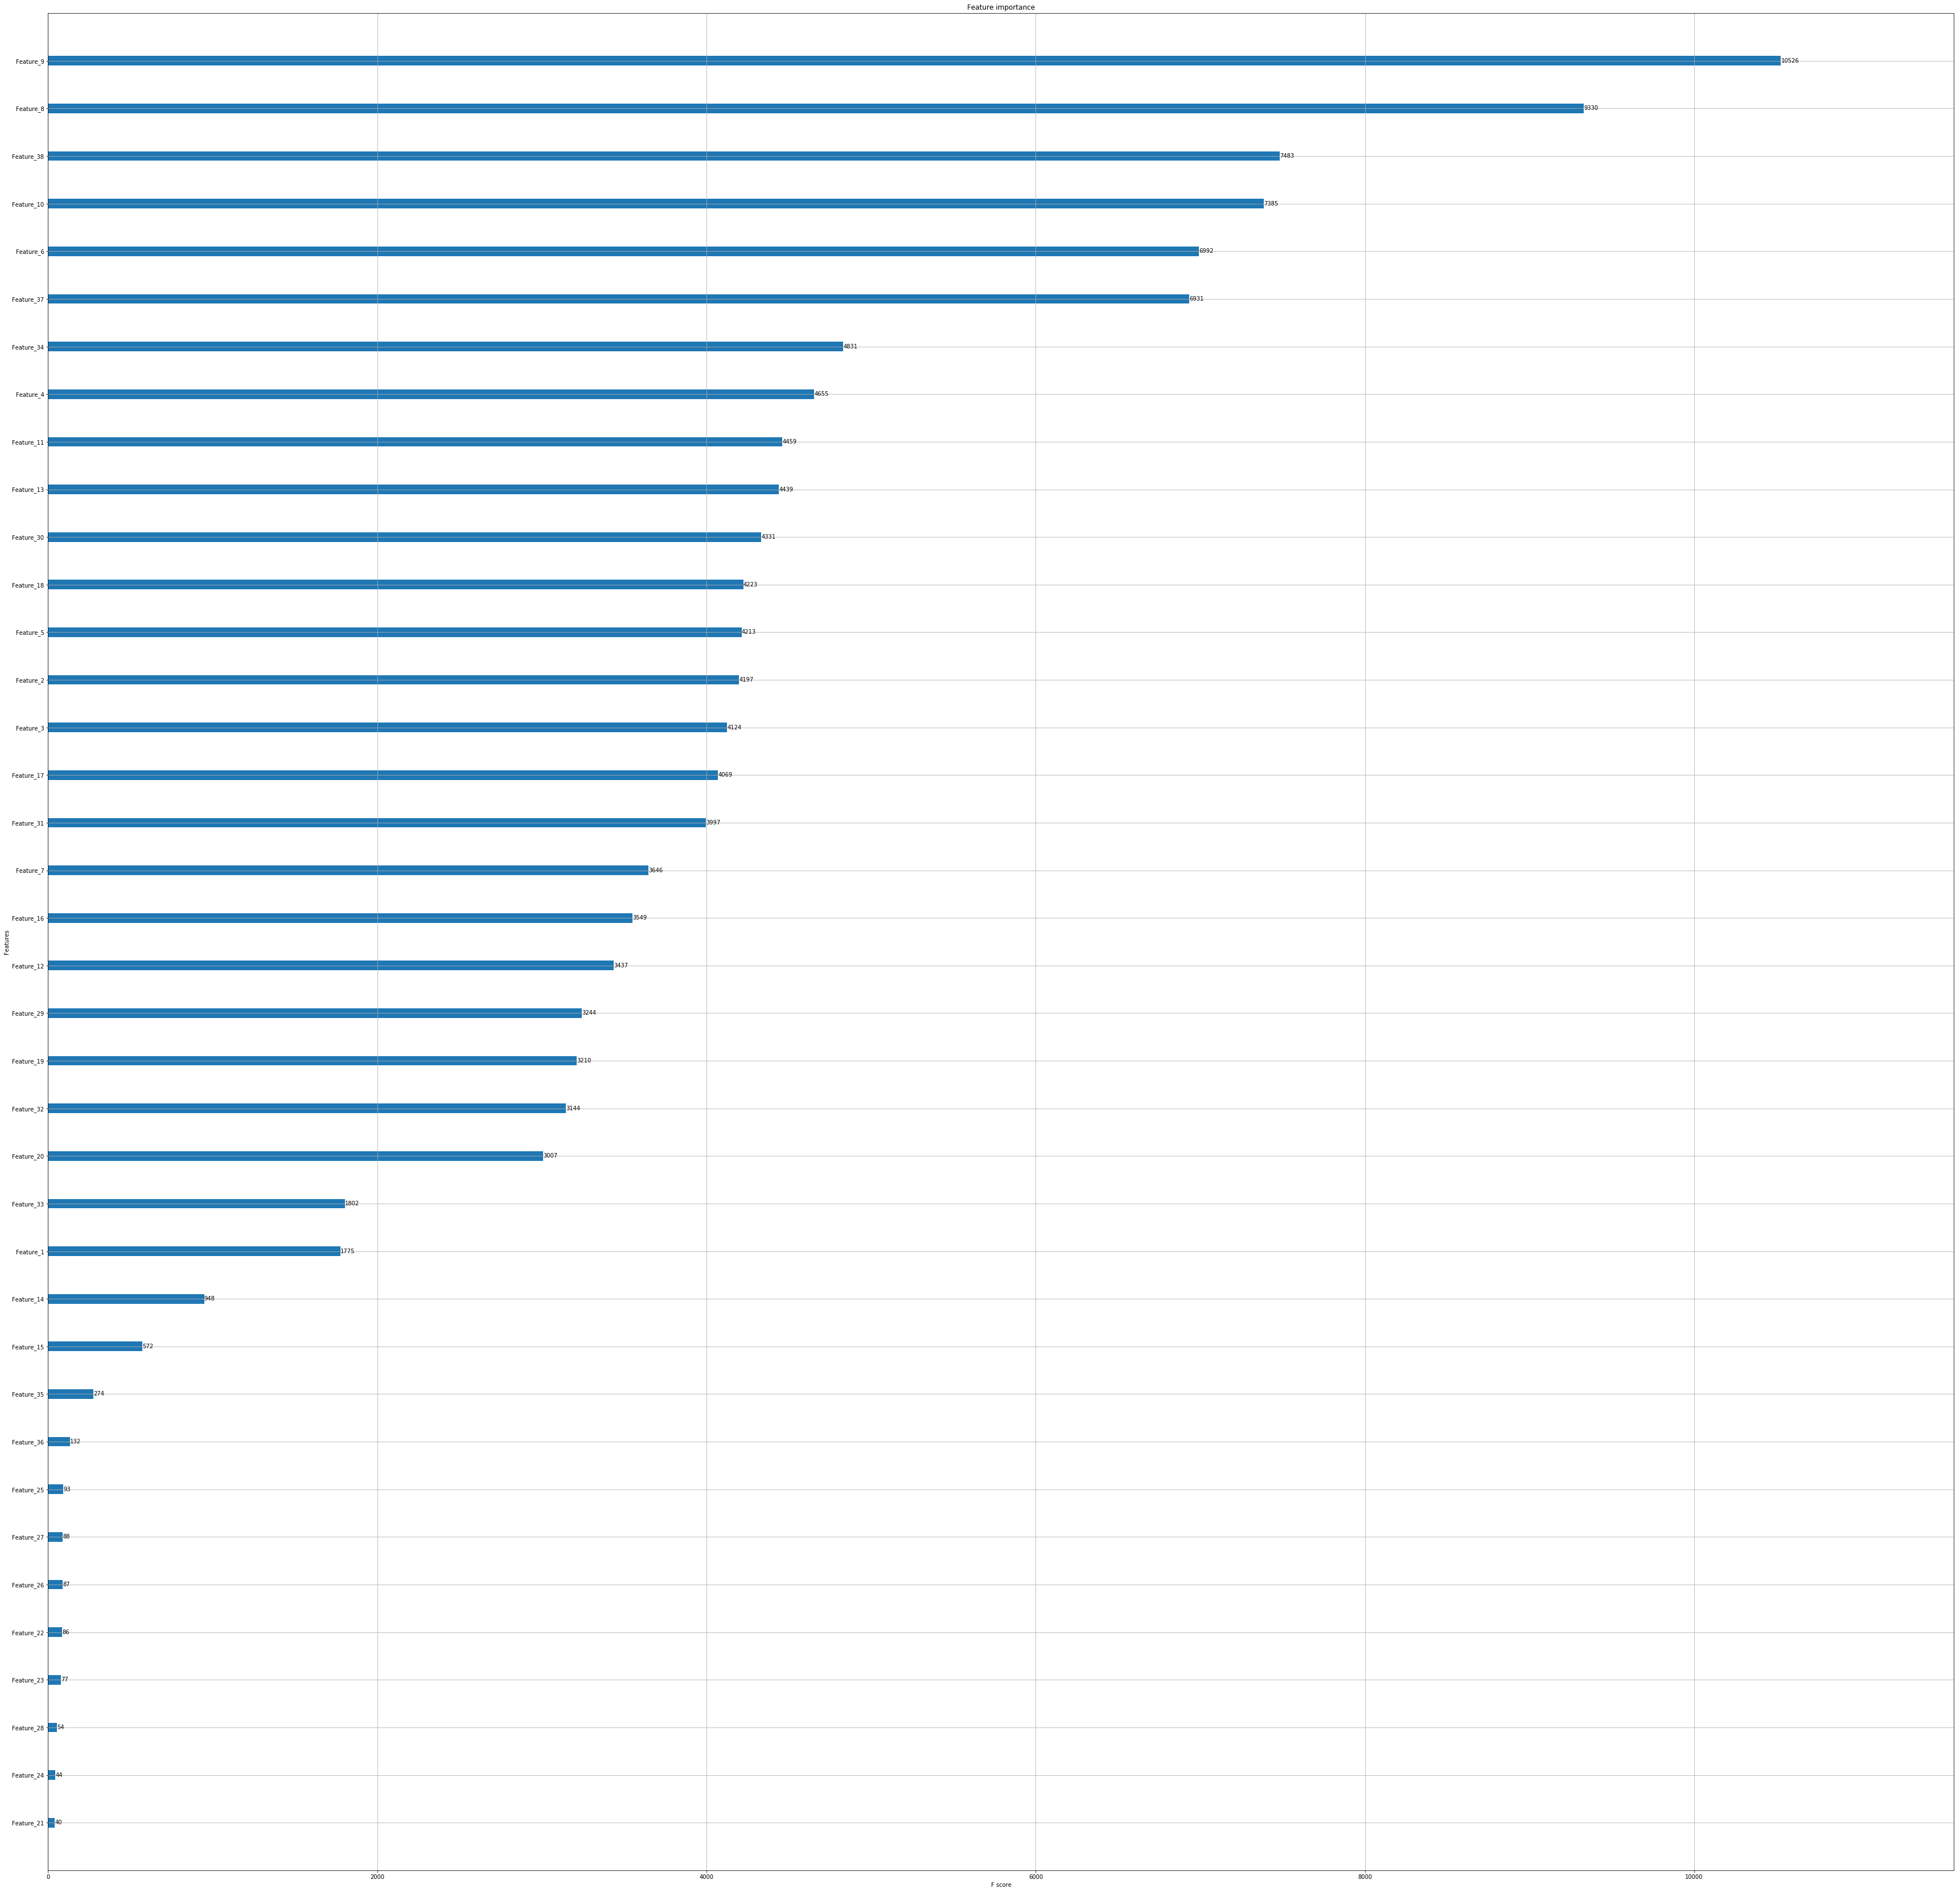

In [39]:
xgb.plot_importance(xgbRegClass)
plt.rcParams['figure.figsize'] = [60, 60]
plt.show()

In [ ]:
#This is a Latitude Regressor, it should be used to predict the latitutde of the trajectories alone
#xgbRegY = xgb.XGBRegressor(n_estimators=100, learning_rate=0.2, gamma=0, subsample=0.75,
#                           colsample_bytree=1, max_depth=7)

#xgbRegY.fit(X_train,y_train,eval_metric='rmse',eval_set=[(X_test,y_test)],verbose=True)
#xgbRegY.save_model("Y_Regressor_1.bin")

In [ ]:
#This is a Longitude Regressor, it should be used to predict the longitude of the trajectories alone
#xgbRegX = xgb.XGBRegressor(n_estimators=100, learning_rate=0.2, gamma=0, subsample=0.75,
#                           colsample_bytree=1, max_depth=7)

#xgbRegX.fit(X_train,y_train,eval_metric='rmse',eval_set=[(X_test,y_test)],verbose=True)
#xgbRegX.save_model("X_Regressor_1.bin")

In [60]:
#Running predictions on the Test Data Using the Classifier trained above
predictions = xgbRegClass.predict(Testing_X)
#predictionsY = xgbRegY.predict(Testing_X)
#predictionsY = xgbRegY.predict(Testing_X)

In [ ]:
#Function to evaluate the Regressor
def evaluate_predictions_Reg(predictionsX,predictionsY,ActualsY,Label_X):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(predictionsX)):
        if str(Label_X[i]) != "nan":
            if (3750901.5068 <= predictionsX[i]) and (predictionsX[i] <= 3770901.5068) and ( -19268905.6133 <= predictionsY[i]) and (predictionsY[i] <= -19208905.6133):
                Answer = 1
            else:
                Answer = 0
            if Answer == ActualsY[i] and ActualsY[i] == 1:
                TP +=1 
            elif Answer != ActualsY[i] and ActualsY[i] == 1:
                FN +=1 
            elif Answer != ActualsY[i] and Answer == 1:
                FP +=1
    
    return TP,FP,FN

In [78]:
#Retrieve the True Positive, False Positive and False Negatives of the regressor
TP,FP,FN = evaluate_predictions_Reg(predictionsX,predictionsY,Output,Label_X)

In [61]:
#Evaluate the predictions made by the Classifier
def evaluate_predictions(predictionsX,ActualsY,Label_X):
    TP = 0
    FP = 0
    FN = 0
    for i in range(len(predictionsX)):
        if str(Label_X[i]) != "nan":
            if predictionsX[i] > 0.5:
                predictionsX[i] = 1
            else:
                predictionsX[i] = 0
            
            if int(predictionsX[i]) == ActualsY[i] and ActualsY[i] == 1:
                TP +=1 
            elif int(predictionsX[i]) != ActualsY[i] and ActualsY[i] == 1:
                FN +=1 
            elif int(predictionsX[i]) != ActualsY[i] and int(predictionsX[i]) == 1:
                FP +=1
    
    return TP,FP,FN

In [62]:
#F1 Metric that is used by the competition.
def F1_Metrics(TP,FP,FN):
    if (TP+FP) == 0:
        p = 0
    else:
        p = (TP/(TP+FP))
    if (TP+FN) == 0:
        r = 0
    else:
        r = (TP/(TP+FN))
    F1 = 2*((p*r)/(p+r))
    return F1

In [63]:
#Retrieve the True Positive, False Positive and False Negatives of the Classifier
TP,FP,FN = evaluate_predictions(predictions,Output_Y,Label_X)

In [64]:
#Return the F1 Metric of the model
F1 = F1_Metrics(TP,FP,FN)

In [65]:
print(F1)

0.8937107984404137


In [91]:
#Final Function to print the answers of the missing trajectories
def write_predictions(predictionsX,Label_X,Traject,Time_Diff,Last_X,Last_Y):
    location = "Classifier_Answers.csv"
    for i in range(len(predictionsX)):
        if str(Label_X[i]) == "nan":
            y = Traject[i]
            if Time_Diff[i] == 0:
                if (3750901.5068 <= Last_X[i]) and (Last_X[i] <= 3770901.5068) and ( -19268905.6133 <= Last_Y[i]) and (Last_Y[i] <= -19208905.6133):
                    Output = 1
                else:
                    Output = 0
                entry = [y,Output]
            else:
                entry = [y,predictionsX[i]]
                
            with open(location, 'a') as f:
                writer = csv.writer(f)
                writer.writerow(entry)
            f.close()

In [50]:
write_predictions(predictions,Output_Feats,Label_X,Traject,Test_Feats['Feature_8'],Test_Feats['Feature_9'],Test_Feats['Feature_10'])